In [1]:
from mxnet import gluon 
from mxnet import ndarray as nd

In [2]:
def transform(data,label):
    return data.astype('float32')/255,label.astype('float32')
mnist_train=gluon.data.vision.FashionMNIST(train=True,transform=transform) 
mnist_test=gluon.data.vision.FashionMNIST(train=False,transform=transform)

In [3]:
data,label=mnist_train[0] 
('example shape:',data.shape,'label',label)

('example shape:', (28, 28, 1), 'label', 2.0)

In [4]:
type( mnist_train  )

mxnet.gluon.data.vision.datasets.FashionMNIST

In [5]:
len(mnist_test)

10000

In [6]:
len(mnist_train)

60000

我们画出前几个样本的内容，和对应的文本标号 

In [7]:
import matplotlib.pyplot as plt
def show_images(images):
    n=images.shape[0] 
    _,figs=plt.subplots(1,n,figsize=(15,15))
    for i in range(n):
        figs[i].imshow(images[i].reshape((28,28)).asnumpy())
        figs[i].axes.get_xaxis().set_visible(False) 
        figs[i].axes.get_yaxis().set_visible(False) 
    plt.show() 

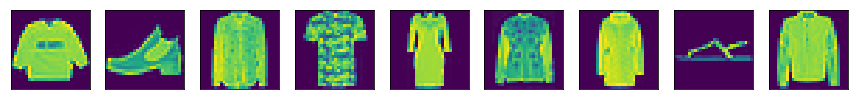

['pullover', 'ankle boot', 'shirt', 't-shirt', 'dress', 'coat', 'coat', 'sandal', 'coat']


In [8]:
def get_text_label(label):
    text_labels=[
        't-shirt','trouser','pullover','dress','coat',
        'sandal','shirt','sneaker','bag','ankle boot'
    ]
    return [text_labels[int(i)] for i in label] 

data,label=mnist_train[0:9]
show_images(data) 
print(get_text_label(label)) 

# 数据读取 
虽然我们可以像以前那样通过yield来定义获取批量数据函数，这里我们直接使用
gluon.data的DataLoader函数，它每次yield一个批量.

In [9]:
batch_size=256
train_data=gluon.data.DataLoader(mnist_train,batch_size,shuffle=True) 
test_data=gluon.data.DataLoader(mnist_test,batch_size,shuffle=False) 

注意到这里我们要求每次从训练数据里读取一个由随机样本组成的批量。
但测试数据则不需要这个要求 。 

## 初始化模型参数 
跟线性模型一样，每个样本会表示成一个向量。我们这里数据是 $24*24$大小的图片
，所以输入向量的长度是 $24*24 = 784 $。因为我们要做多类分类，我们需要一个类
预测这个样本输入此类的概率。为这个数据集有10个类型，所以输出应该是
长为10的向量。这样，我们需要的权重将是一个$784 * 784 $的矩阵 

In [10]:
num_inputs=784
num_outputs=10 
W=nd.random_normal(shape=(num_inputs,num_outputs))
b=nd.random_normal(shape=num_outputs) 

params=[W,b] 

In [11]:
W.shape

(784, 10)

In [12]:
b.shape

(10,)

同之前一样，我们要对模型附上梯： 


In [13]:
for param in params:
    param.attach_grad()

# 定义模型 
在线性回归较长里，我们只需要输出一个标量的yhat使得尽可能的靠近目标值。
但在这里的分类里，我们需要属于每个类别的概率。这些概率需要值为正，
而且加起来等于1，而如果简单的使用y=Wx ,我们不能保证这一点。一个
通常的做饭是通过softmax 函数来将任意的输入归一化成合法的个概率值。 

In [14]:
from mxnet import nd 
def softmax(X):
    exp=nd.exp(X)
    # 假设exp 是矩阵，这里对行进行求和，并要求保留axis 1 ,
    # 就是返回 (nrows,1) 形状的矩阵 
    partition=exp.sum(axis=1,keepdims=True)
    return exp/partition

可以看到，对于随机输入，我们将每个元素变成了非负数，而且每一行加起来为1.

In [15]:
X=nd.random_normal(shape=(2,5))
X_prob=softmax(X)
print(X_prob)
print(X_prob.sum(axis=1))


[[0.01606132 0.4672664  0.16146934 0.33617657 0.01902632]
 [0.27215305 0.16692851 0.04439886 0.39427418 0.12224543]]
<NDArray 2x5 @cpu(0)>

[0.99999994 1.        ]
<NDArray 2 @cpu(0)>


In [16]:
X.shape

(2, 5)

In [17]:
X_prob


[[0.01606132 0.4672664  0.16146934 0.33617657 0.01902632]
 [0.27215305 0.16692851 0.04439886 0.39427418 0.12224543]]
<NDArray 2x5 @cpu(0)>

In [18]:
def net(X):
    return softmax(nd.dot(X.reshape((-1,num_inputs)),W)+b) 

# 交叉熵损失函数 
我们需要定义一个针对预测为概率值的损失函数。其中最常见的是 
交叉熵损失函数，它将两个概率分布的负交叉熵作为目标值，
最小化的这个值等价于这两个概率的相似度。

具体来说，我们先将真实标号表示成一个概率分布，例如如果 y=1,
那么其对应的分布就是一个除了第二个元素为1其他全为0的长为10
的向量，也就是 

In [19]:
def cross_entropy(yhat,y):
    return -nd.pick(nd.log(yhat),y)

# 计算精度
给定一个概率输出，我们将预测概率最高的那个类作为预测的类，然后通过比较
真实标号我们可以计算精度： 

In [20]:
def accuracy(output,label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

我们可以评估一个模型在这个数据上的精度 。
（这两个函数我们之后也会用到，所以也都保存在...) 

In [21]:
X.argmax(axis=1)


[1. 3.]
<NDArray 2 @cpu(0)>

In [22]:
nd.pick?

我们可以评估一个模型在这个数据上的精度。
（这两个函数我们之后也会用到，所以也都保存起来） 

In [23]:
def evaluate_accuracy(data_iterator,net):
    acc=0
    for data,label in data_iterator:
        output=net(data)
        acc+=accuracy(output,label) 
    return acc / len(data_iterator) 

因为我们随机初始化了模型，所以这个模型的精度应该大概是 
1/num_outputs=0.1 

In [24]:
evaluate_accuracy(test_data,net ) 

0.08974609375

# 训练
训练代码跟前面的线性回归非常相似：

In [25]:
import sys
sys.path.append('..')
from utils import SGD
from mxnet import autograd

In [26]:
learning_rate=0.1 
for epoch in range(5):
    train_loss=0.  
    train_acc=0. 
    for data,label in train_data: 
        with autograd.record():
            output=net(data) 
            loss=cross_entropy(output,label)
        loss.backward()
        # 将梯度做平均，这样学习率会对batch size 不那么敏感 
        SGD(params,learning_rate/batch_size)
        train_loss+=nd.mean(loss).asscalar()
        train_acc+=accuracy(output,label)
    test_acc=evaluate_accuracy(test_data,net) 
    print("Epoch %d . loss :%f ,train acc %f,Test acc %f "% 
         (epoch,train_loss/len(train_data),train_acc/len(train_data),test_acc))

Epoch 0 . loss :3.883964 ,train acc 0.441506,Test acc 0.594922 
Epoch 1 . loss :1.900491 ,train acc 0.628031,Test acc 0.664453 
Epoch 2 . loss :1.558492 ,train acc 0.678541,Test acc 0.693945 
Epoch 3 . loss :1.382520 ,train acc 0.704471,Test acc 0.717285 
Epoch 4 . loss :1.270426 ,train acc 0.722235,Test acc 0.732031 
